In [1]:
%reload_ext autoreload
%autoreload 2

import rdkit
rdkit.Chem.Draw.IPythonConsole.ipython_maxProperties = -1

import dgym as dg

# load all data
path = '../../dgym-data'

deck = dg.MoleculeCollection.load(
    f'{path}/DSi-Poised_Library_annotated.sdf',
    reactant_names=['reagsmi1', 'reagsmi2', 'reagsmi3']
)

reactions = dg.ReactionCollection.from_json(
    path = f'{path}/All_Rxns_rxn_library.json',
    smarts_col = 'reaction_string',
    classes_col = 'functional_groups'
)

building_blocks = dg.datasets.disk_loader(f'{path}/Enamine_Building_Blocks_Stock_262336cmpd_20230630.sdf')
fingerprints = dg.datasets.fingerprints(f'{path}/out/Enamine_Building_Blocks_Stock_262336cmpd_20230630_atoms.fpb')

Working on new docking oracles.

In [10]:
from dgym.envs.oracle import DockingOracle, NeuralOracle
from dgym.envs.utility import ClassicUtilityFunction

config = {
    'center_x': 44.294,
    'center_y': 28.123,
    'center_z': 2.617,
    'size_x': 22.5,
    'size_y': 22.5,
    'size_z': 22.5,
    'exhaustiveness': 128,
    'max_step': 20,
    'num_modes': 9,
    'search_mode': 'fast',
    'scoring': 'gnina',
    'refine_step': 3,
    'seed': 5
}

docking_oracle = DockingOracle(
    'ADAM17 affinity',
    receptor_path=f'../../dgym-data/ADAM17.pdbqt',
    config=config
)

# neural_oracle = NeuralOracle(
#     'Mpro affinity',
#     state_dict_path='../../dgym-data/neural/asapdiscovery-SARS-CoV-2-Mpro-GAT-2023.08.25.th'
# )

# create evaluators
docking_utility = ClassicUtilityFunction(
    docking_oracle,
    ideal=(7.5, 9.5),
    acceptable=(7.125, 9.5)
)

Create selection loop.

In [11]:
from tqdm.notebook import tqdm

class Experiment:
    
    def __init__(self, drug_agent, drug_env):
        
        self.drug_agent = drug_agent
        self.drug_env = drug_env
    
    def run(self, num_trials, progress=False):
        
        results = []
        for trial in tqdm(range(num_trials)):

            observations, info = drug_env.reset()

            if progress:
                pbar = tqdm(total = drug_env.budget)
            
            while True:
                action = drug_agent.act(observations)
                observations, _, terminated, truncated, _ = drug_env.step(action)
                try:
                    print(np.nanmax(observations.annotations['ADAM17 affinity']))
                except:
                    pass
                
                if progress:
                    pbar.n = len(drug_env.library)
                    pbar.update()
                
                if terminated or truncated:
                    break

            result = {
                'trial': trial,
                **vars(drug_agent)
            }

            if terminated:
                cost = len(drug_env.library)
                result.update({'cost': cost, 'outcome': 1})

            if truncated:
                result.update({'outcome': 0})

            results.append(result)

        return results

Run experiment.

In [4]:
import numpy as np
scores = docking_utility.oracle(deck)
best = np.argsort(scores)[-400:-300]
best_molecules = [d for d in deck[best] if len(d.reactants) == 2]

In [8]:
from dgym.molecule import Molecule
from dgym.envs.designer import Designer, Generator
from dgym.envs.drug_env import DrugEnv
from dgym.agents import SequentialDrugAgent
from dgym.agents.exploration import EpsilonGreedy

designer = Designer(
    Generator(building_blocks, fingerprints),
    reactions,
    cache = True
)

# drug_env = DrugEnv(
#     designer,
#     library = dg.collection.MoleculeCollection([best_molecules[-80]]).update_annotations(),
#     assays = [docking_utility.oracle],
#     budget = 1_000,
#     utility_function = docking_utility,
# )

sequence = [
    {'name': 'ideate', 'parameters': {'temperature': 0.1, 'size': 10, 'strict': False}},
    {'name': 'ideate', 'parameters': {'temperature': 0.0, 'size': 10, 'strict': True}},
    {'name': 'ADAM17 affinity'},
]

# drug_agent = SequentialDrugAgent(
#     sequence = sequence,
#     utility_function = docking_utility,
#     exploration_strategy = EpsilonGreedy(epsilon = 0.0),
#     branch_factor = 2
# )

# experiment = Experiment(drug_agent, drug_env)
# result = experiment.run(1, progress=True)

In [15]:
import pandas as pd
from dgym.agents import NoisySequentialDrugAgent

results = []
noises = [0.0, 1e-2, 5e-2, 1e-1, 2e-1]
# noises = np.linspace(0, 1, 50)

for noise in tqdm(noises):

    drug_env = DrugEnv(
        designer,
        library = dg.collection.MoleculeCollection([best_molecules[-80]]).update_annotations(),
        assays = [docking_utility.oracle],
        budget = 300,
        utility_function = docking_utility,
    )

    drug_agent = NoisySequentialDrugAgent(
        noise = noise,
        sequence = sequence,
        utility_function = docking_utility,
        exploration_strategy = EpsilonGreedy(epsilon = 0.0),
        branch_factor = 2
    )

    experiment = Experiment(drug_agent, drug_env)
    result = experiment.run(10)
    results.extend(result)

df = pd.DataFrame(results)

In [16]:
import pandas as pd

def ecdf(costs):
    costs_sorted = np.sort(costs)
    probs = 1. * np.arange(1, len(costs) + 1) / len(costs)

    costs_sorted = [0.0, *costs_sorted]
    probs = [0.0, *probs]
    
    return costs_sorted, probs

data = pd.DataFrame()
for noise in noises:
    raw_costs = [r['cost'] for r in df.to_dict('records') if r['noise'] == noise]
    cost, prob = ecdf(raw_costs)
    temp = pd.DataFrame({'cost': cost, 'prob': prob, 'noise': noise})
    data = pd.concat([data, temp])

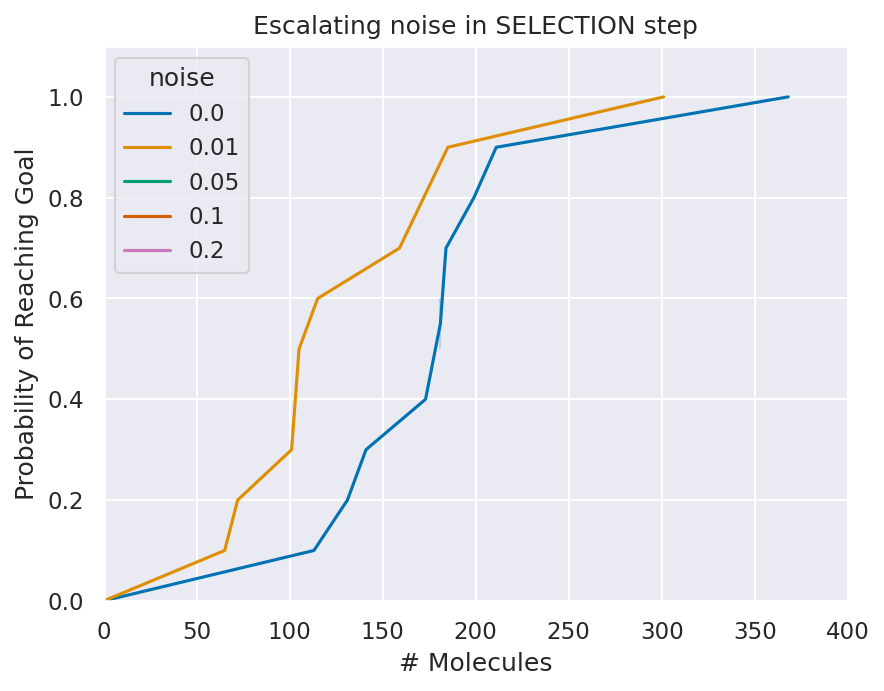

In [19]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set()
g = sns.lineplot(
    data,
    x='cost',
    y='prob',
    hue='noise',
    palette='colorblind',
)

g.set_title('Escalating noise in SELECTION step')
g.set_xlabel('# Molecules')
g.set_ylabel('Probability of Reaching Goal')
g.set_ylim([0, 1.1])
g.set_xlim(0, 400)

plt.gcf().set_dpi(150)
plt.show()